In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import librosa
import os
from IPython.display import Audio
import matplotlib.pyplot as plt

In [37]:
from models.codec.melvqgan.codec_mel import MelCodecEncoder, MelCodecDecoderWithTimbre
from models.codec.melvqgan.melspec import MelSpectrogram
from models.tts.gpt_tts.gpt_tts import GPTTTS
from models.tts.gpt_tts.g2p_old_en import process, PHPONE2ID
from g2p_en import G2p

In [28]:
melvqgan_encoder = MelCodecEncoder(
    d_mel=80,
    d_model=96,
    num_blocks=4,
    out_channels=256,
)

In [29]:
melvqgan_decoder = MelCodecDecoderWithTimbre(
    in_channels=256,
    num_quantizers=1,
    codebook_size=8192,
    codebook_dim=8,
    quantizer_type="fvq",
    use_l2_normlize=True,
    vocos_dim=512,
    vocos_intermediate_dim=4096,
    vocos_num_layers=16,
    ln_before_vq=True,
    use_pe=False,
)

In [30]:
melvqgan_encoder.load_state_dict(torch.load("ckpt/melvqgan/melvqgan_encoder.bin"))
melvqgan_decoder.load_state_dict(torch.load("ckpt/melvqgan/melvqgan_decoder.bin"))

<All keys matched successfully>

In [31]:
gpt_tts = GPTTTS(
    phone_vocab_size=256,
    target_vocab_size=8192,
    hidden_size=1024,
    intermediate_size=4096,
    num_hidden_layers=12,
    num_attention_heads=16,
    pad_token_id=8448,
    bos_target_id=8449,
    eos_target_id=8450,
    bos_phone_id=8451,
    eos_phone_id=8452,
    use_input_embeds=False,
    emb_dim=256,
)

In [32]:
gpt_tts.load_state_dict(torch.load("ckpt/gpt_tts/gpt_tts_small.bin"))

<All keys matched successfully>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
melvqgan_encoder.to(device)
melvqgan_decoder.to(device)
gpt_tts.to(device)

In [69]:
g2p = G2p()

In [82]:
ref_text = "It's time to do! If you are a true duelist."
ref_txt_struct, ref_txt = process(ref_text, g2p)
ref_phone_seq = [p for w in ref_txt_struct for p in w[1]]
ref_phone_id = [PHPONE2ID[p] for p in ref_phone_seq]
print(ref_phone_seq)
print(ref_phone_id)
ref_phone_id = ref_phone_id[:-1]
ref_phone_id = np.concatenate([ref_phone_id, np.array([218])])
print(ref_phone_id)

['<BOS>', 'IH1B', 'TI', 'SE', '|', 'TB', 'AY1I', 'ME', '|', 'TB', 'UW1E', '|', 'DB', 'UW1E', '!', 'IH1B', 'FE', '|', 'YB', 'UW1E', '|', 'AA1B', 'RE', '|', 'AH0B', '|', 'TB', 'RI', 'UW1E', '|', 'DB', 'UW1I', 'AH0I', 'LI', 'IH0I', 'SI', 'TE', '<EOS>']
[5, 116, 185, 175, 218, 180, 61, 142, 218, 180, 198, 218, 71, 198, 0, 116, 105, 218, 209, 198, 218, 13, 172, 218, 28, 218, 180, 173, 198, 218, 71, 199, 30, 140, 115, 179, 181, 6]
[  5 116 185 175 218 180  61 142 218 180 198 218  71 198   0 116 105 218
 209 198 218  13 172 218  28 218 180 173 198 218  71 199  30 140 115 179
 181 218]


In [83]:
target_text = " While recent large-scale text-to-speech models have achieved significant progress, they still fall short in speech quality, similarity, and prosody."
target_txt_struct, target_txt = process(target_text, g2p)
target_phone_seq = [p for w in target_txt_struct for p in w[1]]
target_phone_id = [PHPONE2ID[p] for p in target_phone_seq]
print(target_phone_seq)
print(target_phone_id)
target_phone_id = target_phone_id[1:]
target_phone_id = np.array(target_phone_id)

['<BOS>', 'WB', 'AY1I', 'LE', '|', 'RB', 'IY1I', 'SI', 'AH0I', 'NI', 'TE', '|', 'LB', 'AA1I', 'RI', 'JHE', '|', 'SB', 'KI', 'EY1I', 'LE', '|', 'TB', 'EH1I', 'KI', 'SI', 'TE', '|', 'TB', 'UW1E', '|', 'SB', 'PI', 'IY1I', 'CHE', '|', 'MB', 'AA1I', 'DI', 'AH0I', 'LI', 'ZE', '|', 'HHB', 'AE1I', 'VE', '|', 'AH0B', 'CHI', 'IY1I', 'VI', 'DE', '|', 'SB', 'AH0I', 'GI', 'NI', 'IH1I', 'FI', 'IH0I', 'KI', 'AH0I', 'NI', 'TE', '|', 'PB', 'RI', 'AA1I', 'GI', 'RI', 'EH2I', 'SE', ',', 'DHB', 'EY1E', '|', 'SB', 'TI', 'IH1I', 'LE', '|', 'FB', 'AO1I', 'LE', '|', 'SHB', 'AO1I', 'RI', 'TE', '|', 'IH0B', 'NE', '|', 'SB', 'PI', 'IY1I', 'CHE', '|', 'KB', 'WI', 'AA1I', 'LI', 'AH0I', 'TI', 'IY0E', ',', 'SB', 'IH2I', 'MI', 'AH0I', 'LI', 'EH1I', 'RI', 'AH0I', 'TI', 'IY0E', ',', 'AH0B', 'NI', 'DE', '|', 'PB', 'RI', 'AA1I', 'SI', 'AH0I', 'DI', 'IY0E', '<EOS>']
[5, 206, 61, 139, 218, 171, 127, 179, 30, 149, 181, 218, 138, 15, 173, 132, 218, 174, 136, 100, 139, 218, 180, 82, 136, 179, 181, 218, 180, 198, 218, 174, 170,

In [84]:
ref_phone_id = torch.from_numpy(ref_phone_id).unsqueeze(0).to(device).long()
phone_id = torch.from_numpy(target_phone_id).unsqueeze(0).to(device).long()
phone_ids = torch.cat([ref_phone_id, phone_id], dim=1)

In [85]:
ref_wav_path = "example_wavs/ref/ref_2.wav"
ref_wav, _ = librosa.load(ref_wav_path, sr=16000)
ref_wav = np.pad(ref_wav, (0, 200 - len(ref_wav) % 200))
ref_wav = torch.from_numpy(ref_wav).to(device)
ref_wav = ref_wav[None, :]

In [86]:
vq_emb = melvqgan_encoder(ref_wav.unsqueeze(1))
(
    _,
    vq_indices,
    _,
    _,
    _,
    speaker_embedding,
) = melvqgan_decoder(vq_emb, vq=True, eval_vq=False)
prompt_ids = vq_indices[0, :, :]

In [87]:
gen_tokens = gpt_tts.sample_hf(
    phone_ids,
    prompt_ids,
    max_length=3600,
    temperature=1.0,
    top_k=8192,
    top_p=0.9,
    repeat_penalty=1.0,
)

In [88]:
print(gen_tokens.shape)
vq_post_emb = melvqgan_decoder.vq2emb(gen_tokens.unsqueeze(0))
print(vq_post_emb.shape)
recovered_mel = melvqgan_decoder(
    vq_post_emb, vq=False, speaker_embedding=speaker_embedding
)

torch.Size([1, 687])
torch.Size([1, 256, 687])


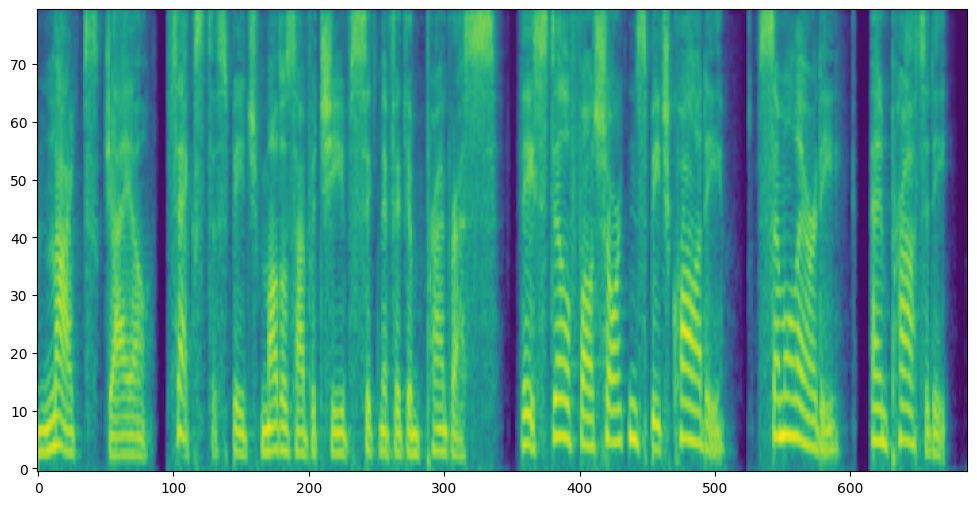

In [89]:
plt.figure(figsize=(12, 6))
plt.imshow(recovered_mel[0].detach().cpu().numpy(), aspect="auto", origin="lower")

In [90]:
recon_path = "example_wavs/gen/mel/gen_2.npy"
np.save(recon_path, recovered_mel.detach().cpu().numpy())

In [91]:
os.system(
    f"python BigVGAN/inference_e2e.py --input_mels_dir=example_wavs/gen/mel --output_dir=example_wavs/gen/wav --checkpoint_file=ckpt/vocoder/g_00490000"
)

Initializing Inference Process..
Loading '/blob/v-shenkai/checkpoints/tts/vocoder/bigvgan/v2/g_00490000'
Complete.
Removing weight norm...
example_wavs/gen/wav/gen_1_generated_e2e.wav
example_wavs/gen/wav/gen_2_generated_e2e.wav


0